In [13]:
import numpy as np
import numba
import matplotlib.pyplot as plt
import scipy.optimize as sopt
from pysimu import ode2numba, ssa
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from solve import solver

In [14]:
%matplotlib notebook

In [15]:
import smib_milano_ex8p1_avr_pss

## Steady state

In [16]:
syst = smib_milano_ex8p1_avr_pss.smib_milano_ex8p1_avr_pss_class()
x0 = np.ones(syst.N_x+syst.N_y)
x0[0] = 0
s = sopt.fsolve(syst.run_problem,x0 )
s[0] = s[0] % (2*np.pi)
print(s)

[4.33439011e-01 1.00000000e+00 9.67394628e-01 2.06389609e-01
 9.99603288e-01 6.12658282e-14 1.00000000e+00 9.99603288e-01
 1.00146878e-01 3.27025976e-01 9.44595542e-01 7.41375885e-02
 1.85936585e-01 2.00000000e-01 1.99879794e-01 9.22393319e-03
 1.07934239e+00 1.50936723e-11 6.12658281e-14]


## Perturbation definition

In [25]:
run = smib_milano_ex8p1_avr_pss.run
@numba.njit(cache=True) 
def perturbations(t,struct): 
    
    struct[0].v_ref = 1.0
    if t>1.0: struct[0].v_ref= 1.02
    return

## Time domain simulation

<IPython.core.display.Javascript object>


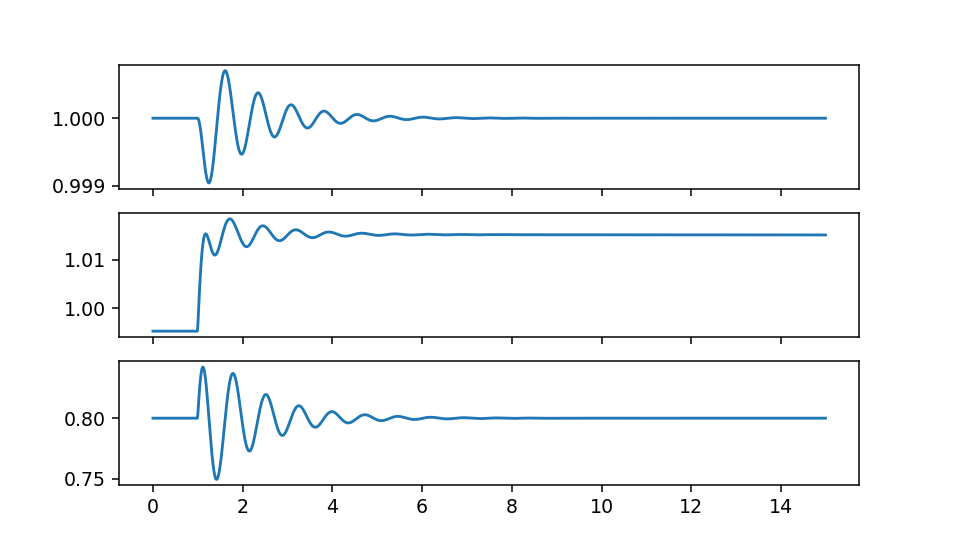

In [26]:
syst.solvern = 4

syst.t_end = 15.0
syst.Dt = 0.010
syst.decimation =1
syst.update()

syst.struct[0].p_m = 0.8
syst.struct[0].K_a = 200
syst.struct[0].K_stab = 0.3

#syst.struct[0].T_pss_1 = 3.6415847004537487              
#syst.struct[0].T_pss_2 = 0.6398979816027691 
#syst.struct[0].D = x_pso[1]
x0 = np.ones((syst.N_x+syst.N_y,1))
x0[0] =x0[0] % np.pi
s = sopt.fsolve(syst.run_problem,x0 )
s[0] =s[0] % np.pi
syst.struct[0].x[:,0] = s[0:syst.N_x]
syst.struct[0].y[:,0] = s[syst.N_x:]

T,X,Y = solver(syst.struct, run, perturbations)

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(7, 4), sharex = True)
axes[0].plot(T[:-1], X[:-1,1])
axes[1].plot(T[:-1], Y[:,0])
axes[2].plot(T[:-1], Y[:,6])

## Interaction

<IPython.core.display.Javascript object>


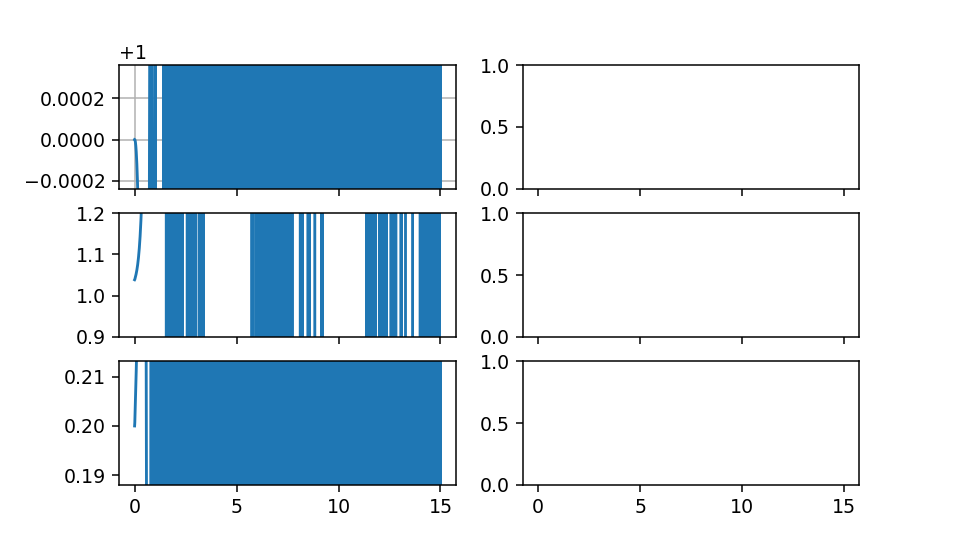

In [35]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(7, 4), sharex = True)

x0 = np.ones((syst.N_x+syst.N_y,1))
x0[0] =0
s = sopt.fsolve(syst.run_problem,x0 )
syst.struct[0].x[:,0] = s[0:syst.N_x]
syst.struct[0].y[:,0] = s[syst.N_x:]

T,X,Y = solver(syst.struct, run, perturbations)

curve_1 = axes[0,0].plot(T[:-1], X[:-1,1])
curve_2 = axes[1,0].plot(T[:-1], Y[:,0])
curve_3 = axes[2,0].plot(T[:-1], Y[:,6])

axes[1,0].set_ylim([0.9,1.2])
#axes[0].set_xlim([0,15])
axes[0,0].grid(True)
fig.canvas.draw()

def update(K_a = 200.0):
    syst.struct[0].K_a = K_a 
    x0 = np.ones((syst.N_x+syst.N_y,1))
    x0[0] = 0
    s = sopt.fsolve(syst.run_problem,x0 )
    syst.struct[0].x[:,0] = s[0:syst.N_x]
    syst.struct[0].y[:,0] = s[syst.N_x:]

    Fx = syst.struct[0].Fx
    Fy = syst.struct[0].Fy
    Gx = syst.struct[0].Gx
    Gy = syst.struct[0].Gy   
    A = Fx - Fy @ np.linalg.inv(Gy) @ Gx
    eig,eigv = np.linalg.eig(A)
          
    T,X,Y = solver(syst.struct, run, perturbations)
    curve_1[0].set_xdata(T[:-1])
    curve_2[0].set_xdata(T[:-1])
    curve_3[0].set_xdata(T[:-1])
    curve_1[0].set_ydata(X[:-1,1])
    curve_2[0].set_ydata(Y[:,0])
    curve_3[0].set_ydata(Y[:,6])    

    fig.canvas.draw()
update()

In [31]:
interact(update, 
         K_a =widgets.FloatSlider(min=1.0,max=300,step=0.1,value=200.0, continuous_update=False),
        );

interactive(children=(FloatSlider(value=200.0, continuous_update=False, description='K_a', max=300.0, min=1.0)…

<IPython.core.display.Javascript object>


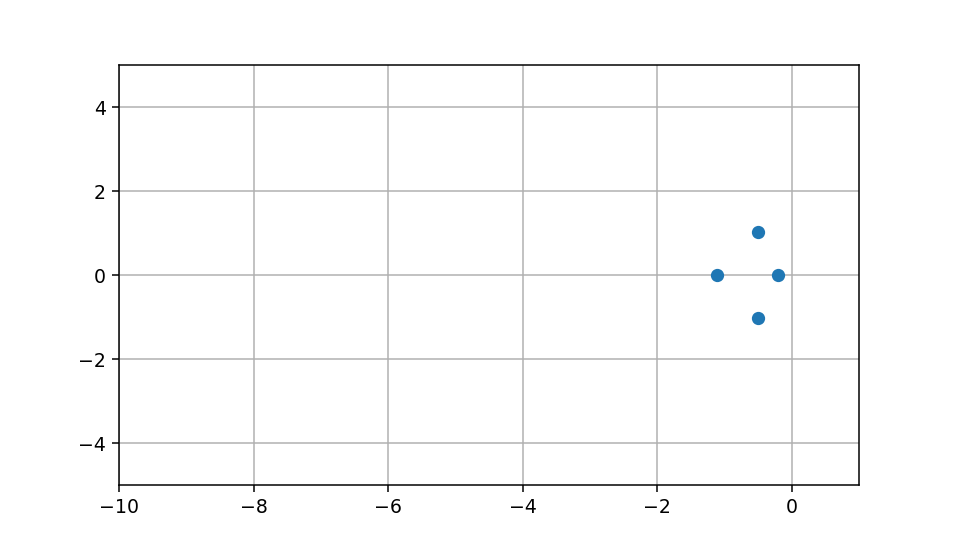

0.4022393928031167
[-1.         -1.         -0.81503897 -0.81503897 -0.07851379 -0.07851379
 -1.        ]


In [33]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(7, 4), sharex = True)
curve_1 = axes.plot(eig.real,eig.imag/(2*np.pi),'o')
axes.set_xlim((-10,1))
axes.set_ylim((-5,5))
axes.grid(True)
def update_ka(p_m=0.2,K_a = 100.0, K_stab = 0.0):
    syst.struct[0].p_m = p_m 
    syst.struct[0].K_a = K_a 
    syst.struct[0].K_stab = K_stab 
    x0 = np.ones((syst.N_x+syst.N_y,1))
    x0[0] =0.0
    s = sopt.fsolve(syst.run_problem,x0 )
    s[0] = s[0] % (2*np.pi)
    syst.struct[0].x[:,0] = s[0:syst.N_x]
    syst.struct[0].y[:,0] = s[syst.N_x:]
    print(f'{s[0]}')
    Fx = syst.struct[0].Fx
    Fy = syst.struct[0].Fy
    Gx = syst.struct[0].Gx
    Gy = syst.struct[0].Gy   
    A = Fx - Fy @ np.linalg.inv(Gy) @ Gx
    eig,eigv = np.linalg.eig(A)
    omegas = eig.imag
    sigmas = eig.real

    freqs = omegas/(2*np.pi)
    zetas = sigmas/np.sqrt(sigmas**2+omegas**2)
    curve_1[0].set_xdata(eig.real)
    curve_1[0].set_ydata(eig.imag/(2*np.pi))
    
    fig.canvas.draw()
    print(zetas)
update_ka()


In [ ]:
interact(update_ka, 
         p_m =widgets.FloatSlider(min=0,max=1,step=0.01,value=0.8, continuous_update=False),
         K_a =widgets.FloatSlider(min=1.0,max=300,step=0.1,value=200.0, continuous_update=False),
         K_stab =widgets.FloatSlider(min=0,max=1,step=0.01,value=0.0, continuous_update=False)
        );